## A Practical Diffusion Path for Sampling

In this notebook, we will reproduce the experiment made by Anna Korba and O. Chebab in the article: "[A Practical Diffusion Path for Sampling](https://arxiv.org/abs/2406.14040)", 2024.

The main goal is to draw samples from complex target distribution. (...) On s'occupe de la rédaction ensuite car flemme sa mèèèèère


In [20]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal

### I. Sampling a Gaussian Mixture with 16 modes

We will compare 3 methods to sample a target distribution which is a Gaussian Mixture with 16 modes : 
- Unadjusted Langevin Algorithm (ULA)
- ULA with geometric path 
- ULA with dilation path

We consider that sample from the target distribution are not available, which make the task of using diffusion models more complicated (except for the dilation path). 

Convergence metrics (aims to quantify the distance between intermediaries distributions and the target distribution) : DEFINE THEM
- KSD
- KL
- MMS

Parameters of the experiment : 
- 1000 particles 
- 10000 iterations
- step size of 0.001 (constant)

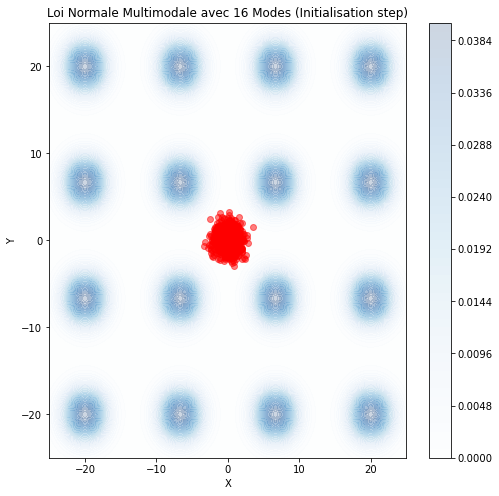

In [4]:
# Define the centers for each mode

x = np.linspace(-20, 20, 4)
y = np.linspace(-20, 20, 4)

## meshgrid : takes two 1D arrays and produces two 2D matrices corresponding to all pairs of (x, y) in the two arrays
xx, yy = np.meshgrid(x, y)

## ravel : returns a contiguous flattened array (Matrice to concatenated vector)
## np.c_ : prend en entrée des vecteurs et les concatène en une matrice à 2 colonnes

centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix

covariance = np.array([[4, 0], [0, 4]])  # cov = 4*I_2

## dstack : stack arrays in sequence along the third axis (stocker les matrices les unes sur les autres) 
## ici pos[i, j] = [x[i], y[j]]

x_axis = np.linspace(-25, 25, 500)
y_axis = np.linspace(-25, 25, 500)

xx_axis, yy_axis = np.meshgrid(x_axis, y_axis)
pos = np.dstack((xx_axis, yy_axis))

# Compute the pdf for each center and sum them
pdf = np.zeros(xx_axis.shape)
for center in centers:
    rv = multivariate_normal(center, covariance) # On fixe la normale
    pdf += rv.pdf(pos) # On évalue la densité de cette loi sur la grille des points et on somme

## Initialisation : we draw a sample from a Standard Normal Distribution

sample = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 1000)

x = sample[:, 0]
y = sample[:, 1]

# Plot the result

plt.figure(figsize=(8, 8))
plt.contourf(xx_axis, yy_axis, pdf, levels=50, cmap='Blues', alpha=0.2) 
## levels : nombre de niveaux de couleurs ; cmap : choix de la palette de couleurs ; alpha : transparence
plt.colorbar()

plt.scatter(x, y, alpha=0.5, color = 'red')
plt.title('Loi Normale Multimodale avec 16 Modes (Initialisation step)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


We consider that we have access to the gradient of the score of the target distribution, which means that we can implement the ULA. 

We know that the score vector for a $ \mathcal{N}(\mu, \Sigma) $ is given by : 

$ \nabla \log p(x) = \Sigma^{-1}(x- \mu) $ 

As, a Multimodal Normal Distribution as a density that can be written as a weighted sum of $\mathcal{k}$ densities Multivariate Normal : 

$ f(x) = \sum_{i=1}^{k} w_i \cdot \mathcal{N}(x \mid \mu_i, \Sigma_i) $

where :

- $ (w_i)_{i:n} $ is the vector of weights of the $\mathcal{k}$ normal distributions 
- $\mathcal{N}(x \mid \mu_i, \Sigma_i) $ is the density of the i^th normal distribution which composes the multimodal
- $\sum_{i=1}^{k} w_i = 1 $, guarantees that the function is a density

#### Gradient of the score of a multimodal : 

$ \nabla \log f(x)$ is computed as follow : 

$ \nabla \log f(x) = \sum_{i=1}^{k} \frac{w_i}{f(x)} \cdot \Sigma_i^{-1} (x - \mu_i) \cdot \mathcal{N}(x \mid \mu_i, \Sigma_i) $

Where :
- $ f(x) $ is the density of the multimodal distribution

----> Ecrire la suite sur le fait que l'on prend le gradient du score de l'échantillon de taille n qui donc est la somme des log(f(x_i)), où chacun des f(x_i) est la densité d'une multimodale composée d'une somme équipondérée de normales dont les centres sont différents mais la covariance est la même. 




------------------------------------------------------------------------------------------------------------------------------------------------------
Function to generate a graph of 2-dimensionnal Gaussian Mixture Distribution

In [11]:
def generate_multimodal(centers, covariances, weights, plot_sample=None): 

    n_components = len(weights)

    if n_components != len(centers) or n_components != len(covariances):
        raise ValueError('The number of centers, covariances and weights should be the same')
    
    graph_len = max(max(centers[:, 0]),  max(centers[:, 1])) + 5

    x_axis = np.linspace(-graph_len, graph_len, 500)
    y_axis = np.linspace(-graph_len, graph_len, 500)

    xx_axis, yy_axis = np.meshgrid(x_axis, y_axis)
    pos = np.dstack((xx_axis, yy_axis))
    
    # Compute the pdf for each center and sum them

    pdf = np.zeros(xx_axis.shape)

    for i in range(n_components):
        center = centers[i]
        covariance = covariances[i]
        weight = weights[i]

        rv = multivariate_normal(center, covariance) # On fixe la normale
        pdf += weight * rv.pdf(pos) # On évalue la densité de cette loi sur la grille des points et on somme (pondéremment)

    # Plot the result

    plt.figure(figsize=(8, 8))
    plt.contourf(xx_axis, yy_axis, pdf, levels=50, cmap='Blues', alpha=0.2) 
    ## levels : nombre de niveaux de couleurs ; cmap : choix de la palette de couleurs ; alpha : transparence
    plt.colorbar()
    
    if plot_sample is not None:
        x = plot_sample[:, 0]
        y = plot_sample[:, 1]
        plt.scatter(x, y, alpha=0.5, color = 'red')

    plt.title('Mixture of Gaussian Distributions density')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

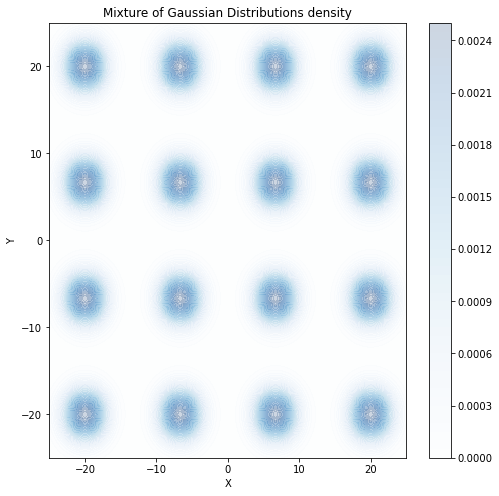

In [12]:
generate_multimodal(centers, [covariance]*16, [1/16]*16)

In [13]:
def evaluate_gaussian_mixture(x, weights, centers, covariances): 
    
    n_components = len(weights)

    pdf = np.zeros(x.shape[0])

    for i in range(n_components):
        center = centers[i]
        covariance = covariances[i]
        weight = weights[i]

        rv = multivariate_normal(center, covariance) # On fixe la normale
        pdf += weight * rv.pdf(x) # On évalue la densité de cette loi sur la grille des points et on somme (pondéremment)

    return pdf

In [14]:
evaluate_gaussian_mixture(np.array([0]), np.array([1]), np.array([0]), np.array([1]))

array([0.39894228])

In [15]:
def grad_multimodal(x, weights, centers, covariances): 
    
    n_components = len(weights)

    if centers.shape[0] != n_components or covariances.shape[0] != n_components:
        raise ValueError("The number of weights, means and covariances should be the same")
    
    grad = np.zeros(x.shape)
    for i in range(n_components):
        center = centers[i]
        covariance = covariances[i]
        weight = weights[i]

        rv = multivariate_normal(center, covariance)
        pdf = rv.pdf(x)
        
        grad += weight * np.linalg.inv(covariance) @ (x - center) * pdf

    return grad / evaluate_gaussian_mixture(x, weights, centers, covariances)
    

In [16]:
grad_multimodal(np.array([0, 0]), np.array([1/16]*16), centers, [covariance]*16)

AttributeError: 'list' object has no attribute 'shape'

In [33]:
# We define the Unadjusted Langevin Algorithm (constant step + non stochastic gradient)

def ULA(x_init, n_iter, step, weights, centers, covariances): 
    
    n_components = len(weights)

    x = x_init # Initialisation with a 2-dimensional standerd normal distribution
    size_sample = x_init.shape[0]

    #x_tab = np.zeros((n_iter, size_sample))
    x_tab = []

    for i in tqdm(range(n_iter)):

        # Each iteration we compute the gradient of the target distribution and update the position of the particle
        grad = np.zeros(2)

        for element in x:
            grad += grad_multimodal(element, weights, centers, covariances) 

        x_new = []

        for element in x:     
            element = element + step * grad + np.sqrt(2 * step) * np.random.normal(size=2)
            x_new.append(element)
        
        x = x_new

        x_tab.append(x_new)
    
    return x_tab

In [42]:
x = np.linspace(-20, 20, 4)
y = np.linspace(-20, 20, 4)

xx, yy = np.meshgrid(x, y)
centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix

covariances = np.array([[[4, 0], [0, 4]]]*16)  # cov = 4*I_2 -> 16 times the same covariance matrix
weights = np.ones(16) / 16
sample = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 5)

In [45]:
result = ULA(sample, 10000, 0.01, weights, centers, covariances)

 65%|██████▍   | 6463/10000 [04:53<03:42, 15.89it/s]/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_79921/511919727.py:19: RuntimeWarning: invalid value encountered in true_divide
  return grad / evaluate_gaussian_mixture(x, weights, centers, covariances)
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_79921/511919727.py:19: RuntimeWarning: divide by zero encountered in true_divide
  return grad / evaluate_gaussian_mixture(x, weights, centers, covariances)
100%|██████████| 10000/10000 [07:32<00:00, 22.11it/s]


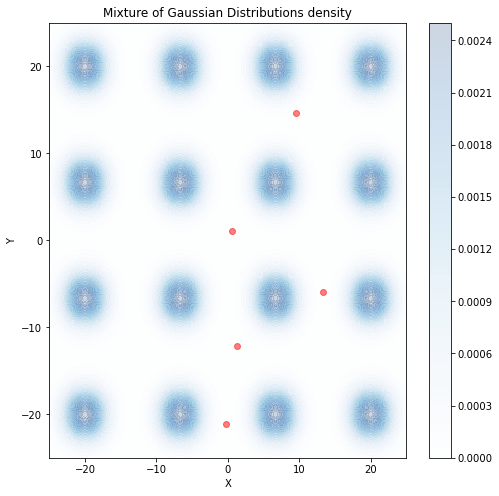

In [54]:
generate_multimodal(centers, covariances, weights, np.array(result[4000]))